In [120]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Part 1

In [66]:
a = 5.64e-10
kalpha = 1.54e-10
kbeta = 1.39e-10

In [67]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(x, y, p0):
    popt, pcov = curve_fit(gauss, x, y, p0)
    return popt[1], popt[2]

In [68]:
def valid_hkl(h, k, l):
    return ((h % 2 == 1) and (k % 2 == 1) and (l % 2 == 1)) or ((h % 2 == 0) and (k % 2 == 0) and (l % 2 == 10))

In [69]:
def potential_match(theta, delta_theta):
    potential_matches = []
    for h in range(6):
        for k in range(6):
            for l in range(6):
                if not valid_hkl(h, k, l): continue
                for wavelength in [kalpha, kbeta]:
                        if abs(wavelength / 2 * np.sqrt(h ** 2 + k ** 2 + l ** 2) / a) < 1:
                            theta_thy = np.degrees(np.arcsin(wavelength / 2 * np.sqrt(h ** 2 + k ** 2 + l ** 2) / a))
                        else:
                            theta_thy = -100000
                        if abs(theta_thy - theta) < delta_theta:
                            potential_matches.append(
                                (f'{h}{k}{l}', wavelength * 1e10)
                            )                    
    return potential_matches

In [70]:
columns = ['theta', 'intensity']
nacl_powder = pd.read_csv('data/NaCl_powder.tsv', sep='\t', skiprows=1, encoding='unicode_escape')
nacl_powder.columns = columns

Text(0.5, 1.0, 'NaCl Powder Diffraction')

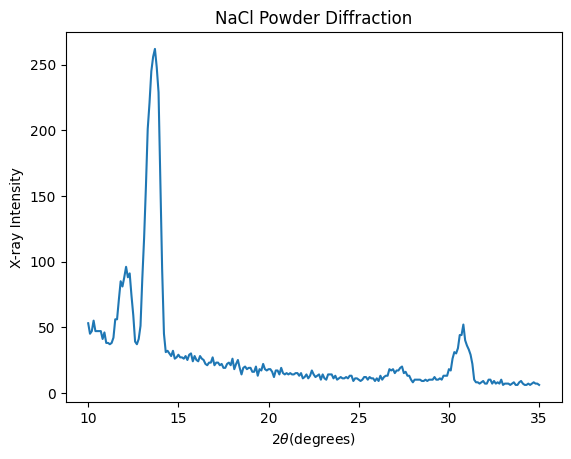

In [71]:
plt.plot(
    nacl_powder.theta,
    nacl_powder.intensity
)

plt.xlabel(r'$2\theta$(degrees)')
plt.ylabel('X-ray Intensity')
plt.title('NaCl Powder Diffraction')

In [72]:
def intensity_graph(df, plane):
    plt.plot(df['theta'], df['intensity'])
    plt.title(f'Plane [{plane}]')
    plt.xlabel(r'$\theta$ (degrees)')
    plt.ylabel(r'X-ray Intensity (Impl/s)')

In [73]:
def extract_peak(data, l, r, show=False):
    data = data[(data.theta >= l) & (data.theta <= r)]
    if show: intensity_graph(data, 'Identifying Peaks')
    t, dt = fit_gaussian(data.theta, data.intensity, [1000, (l + r) / 2, 1])
    return t, dt

Text(0.5, 1.0, 'NaCl Powder Diffraction')

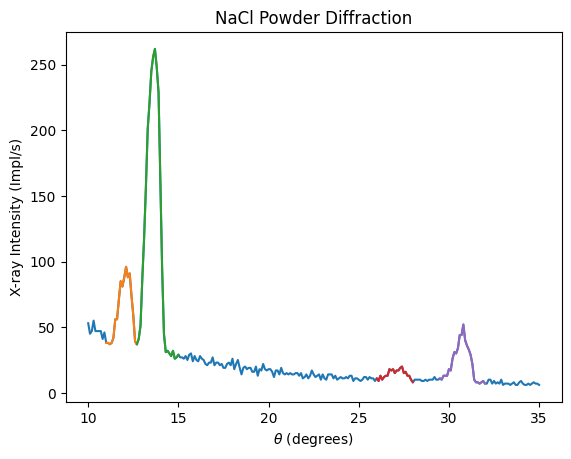

In [74]:
intensity_graph(nacl_powder, 'Nacl Powder Diffraction')
extract_peak(nacl_powder, 11, 12.7, True)
extract_peak(nacl_powder, 12.7, 15, True)
extract_peak(nacl_powder, 26, 28, True)
extract_peak(nacl_powder, 29.5, 32, True)
plt.title('NaCl Powder Diffraction')

In [75]:
theta = []
dtheta = []
for l, r in [(11, 12.7), (12.7, 15), (26, 28), (29.5, 32)]:
    t, dt = extract_peak(nacl_powder, l, r)
    theta.append(t)
    dtheta.append(dt)

In [76]:
theta_table = []
dtheta_table = []
planes = []
wavelengths = []

for t, dt in zip(theta, dtheta):
    matches = potential_match(t, dt)
    print(matches)
    for p, wavelength in matches:
        theta_table.append(t)
        dtheta_table.append(dt)
        planes.append(p)
        wavelengths.append(wavelength)
        
powder = pd.DataFrame({
    r'$\theta$': theta_table,
    r'$\Delta \theta$': dtheta_table,
    r'$\lambda (\AA)$': wavelengths,
    r'Plane': planes
})

[('111', 1.3900000000000001)]
[('111', 1.54)]
[('113', 1.54), ('131', 1.54), ('311', 1.54)]
[]


In [77]:
latex = powder.to_latex(index=False, column_format='|c|c|c|c|', float_format='{:.2f}'.format)
for old, new in [

    (r'\toprule', r'\hline'),
    (r'\midrule', r'\hline'),
    (r'\bottomrule', r'\hline')
]:
    latex = latex.replace(old, new)

print(latex)

\begin{tabular}{|c|c|c|c|}
\hline
$\theta$ & $\Delta \theta$ & $\lambda (\AA)$ & Plane \\
\hline
12.01 & 0.58 & 1.39 & 111 \\
13.60 & 0.39 & 1.54 & 111 \\
27.07 & 0.86 & 1.54 & 113 \\
27.07 & 0.86 & 1.54 & 131 \\
27.07 & 0.86 & 1.54 & 311 \\
\hline
\end{tabular}


# Part 2

In [90]:
def fit_gaussian(x, y, p0):
    popt, _ = curve_fit(gauss, x, y, p0)
    return (popt[0], popt[1])

In [91]:
def extract_peak(data, l, r, show=False):
    data = data[(data.theta >= l) & (data.theta <= r)]
    if show: intensity_graph(data, 'Identifying Peaks')
    A, t = fit_gaussian(data.theta, data.intensity, [1000, (l + r) / 2, 1])
    return A, t

In [93]:
theta = []
intensity = []
for l, r in [(11, 12.7), (12.7, 15), (26, 28)]:
    A, t = extract_peak(nacl_powder, l, r)
    intensity.append(A)
    theta.append(t)

In [99]:
Line = [1, 2, 3]
Plane = ['111', '111', '113']
p = [8, 8, 24]
wavelengths = [1.39e-10, 1.54e-10, 1.54e-10]

powder = pd.DataFrame({
    'Line': Line,
    'Plane': Plane,
    'theta': theta,
    'wavelength': wavelengths,
    'intensity': intensity,
    'p': p
}) 

In [104]:
powder['sin_lambda'] = np.sin(np.radians(powder.theta)) / powder.wavelength * 1e-10

In [116]:
powder['fNa'] = [9, 9, 7]
powder['fCl'] = [13.8, 13.6, 9.5]

In [117]:
powder['F'] = 4 * (powder.fNa - powder.fCl)
powder['F2'] = powder.F ** 2

In [118]:
powder['Lp'] = powder.F2 * powder.p * (1 + np.cos(np.radians(2 * powder.theta)) ** 2) / (np.sin(np.radians(powder.theta)) ** 2 * np.cos(np.radians(powder.theta)))
powder['thy'] = powder.Lp / max(powder.Lp)
powder['exp'] = powder.intensity / max(powder.intensity)

In [119]:
powder

,Line,Plane,theta,wavelength,intensity,p,sin_lambda,fNa,fCl,F,F2,thy,exp,Lp
0,1,111,12.012454,1.390000e-10,87.790051,8,0.149730,9,13.8,-19.2,368.64,1.000000,0.330194,127678.928900
1,2,111,13.598390,1.540000e-10,265.874129,8,0.152672,9,13.6,-18.4,338.56,0.707158,1.000000,90289.126399
2,3,113,27.073093,1.540000e-10,17.697045,24,0.295537,7,9.5,-10.0,100.00,0.136876,0.066562,17476.157699
